# [NTDS'17] assignment 3: spectral graph theory
[ntds'17]: https://github.com/mdeff/ntds_2017

[Michaël Defferrard](http://deff.ch), [EPFL LTS2](http://lts2.epfl.ch)

The first two assignments were designed to warm you up. This third assignment is closer to what we expect you to do for the projects. It mainly misses the exploratory data analysis part (though there is some in sections 5.1 and 5.2). As such, our plan for this assignement encompasses data collection and exploitation, and goes as follows:
1. Data collection: use a web API to collect the musical genre of 2000 songs.
2. Feature extraction: compute features from audio tracks.
3. Graph construction: construct a nearest-neighbor graph from the features.
4. Eigendecomposition: factorization of the graph Laplacian (c.f. spectral graph theory).
5. Visualization & Clustering: using the graph and eigenvectors to visualize the dataset and to cluster the tracks.
6. Conclusion: a reflexion about what we did (though realisations are scattered all along).

The data we are using for this assignment is a subset of the [Free Music Archive dataset](https://github.com/mdeff/fma), a collection of 1TB of music with metadata released under a permissive license.

In [1]:
%matplotlib inline

import configparser
import os

import requests
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import sparse, stats, spatial
import scipy.sparse.linalg
from sklearn import preprocessing, decomposition
import librosa
import IPython.display as ipd

import matplotlib.colors as mcolors #Newly added
import operator                     #Newly added

plt.rcParams['figure.figsize'] = (17, 5)

If the above cell fails, it's most probably because you miss a package. Install them with e.g. `conda install tqdm librosa` (or `pip install tqdm librosa`).

## 1 Data collection

Like in any data project, the first part of the assignment is to collect some data. 

### 1.1 Get the genre of a single track

As often, we need an API key for certain operations. Add the following to your `credentials.ini` file. I gave a key during the lab on November 6. If you were not there, ask one of your classmates. Please do not over-use the key (it'll otherwise be banned for everybody).
```
[freemusicarchive]
api_key = MY-KEY
```

In [2]:
# Read the confidential API key.
credentials = configparser.ConfigParser()
credentials.read('credentials_new.ini')
api_key = credentials.get('freemusicarchive', 'api_key')

Your first task is to develop a function to retrieve the genre ID of a track given its track ID using the [FMA API](https://freemusicarchive.org/api).

Hints:
* A track might have multiple genres associated to it. Always return the first one and discard the others.
    * Note: you should never discard data blindly. I selected the tracks so that this is not a problem.
* The `get_genre` function takes an integer as input, the track ID, and returns another integer, the genre ID.

In [3]:
def get_genre(track_id):
    """Returns the genre of a track by querying the API."""
    
    TRACK_ID = track_id
    
    BASE_URL = 'https://freemusicarchive.org/api/get/tracks.json'
    
    url = '{}?track_id={}&api_key={}'.format(BASE_URL, TRACK_ID, api_key)
    
    response = requests.get(url).json()
    
    print('Working on Track ID : {}'.format(track_id))
    
    genre_id = int(response['dataset'][0]['track_genres'][0]['genre_id'])
    
    return genre_id

# A correct implementation should pass the below test.
assert get_genre(1219) == 38

Working on Track ID : 1219


### 1.2 Create a table of tracks

The `fma_tracks.csv` file contains a list of 2'000 track IDs that we will use through the assignment.

In [4]:
tracks = pd.read_csv('../data/fma_tracks.csv', index_col=0)
print('You got {} track IDs.'.format(len(tracks)))

You got 2000 track IDs.


Once imported by pandas, each row of the DataFrame represents a track. The index is the track ID and the genre column is the genre ID of each track.

In [5]:
tracks.iloc[125:130]

,genre
track_id,
11204,21
11264,88
11268,89
11298,21
11299,21


### 1.3 Add the genre to the table

The genre column contains an integer which represents the genre of the track, i.e. the return value of the `get_genre` function you developed. Because I'm a nice guy, I retrieved the genre for most tracks. Only the genre of the first 10 tracks is missing (zero is a placeholder value).

In [6]:
tracks.head(10)

,genre
track_id,
2,0
5,0
182,0
255,0
256,0
368,0
459,0
574,0
676,0


Your task is to replace the 10 zeros with the correct genre IDs.

Hints:
* As we want to apply one function (`get_genre`) to many data samples (the track IDs), you may want to use a functional approach. Check out `tracks.apply()` or the built-in `map`. In Python, you can declare an [anonymous function](https://en.wikipedia.org/wiki/Anonymous_function) as `lambda x: x + 1`.
* Your table should look like the above table, except with the correct number instead of zeros.

In [7]:
# Your code here.

#Generating a list of Track IDs that don't have a Genre ID
valid_tracks = list(tracks.index[tracks['genre'] == 0])

#Generating Genre IDs for each of those tracks
assigned_genre_list = list(map(get_genre, valid_tracks))

#Assigning those obtained Genre IDs to the Track IDs in the DataFrame
list(map(lambda x : operator.setitem(tracks.loc, x[0], x[1]), list(zip(valid_tracks, assigned_genre_list))))
tracks.head(10)

Working on Track ID : 2
Working on Track ID : 5
Working on Track ID : 182
Working on Track ID : 255
Working on Track ID : 256
Working on Track ID : 368
Working on Track ID : 459
Working on Track ID : 574
Working on Track ID : 676
Working on Track ID : 690


,genre
track_id,
2,21
5,21
182,27
255,12
256,31
368,89
459,36
574,25
676,21


### 1.4 Save the data

To avoid having to collect the data everytime you restart the IPython kernel, save the DataFrame as a CSV file.

In [8]:
tracks.to_csv('../data/fma_tracks_with_genre.csv')

You can now load it back with the following call instead of running the code in sections 1.1 to 1.3.

In [9]:
tracks = pd.read_csv('../data/fma_tracks_with_genre.csv', index_col=0)

### 1.5 Data cleaning

Data cleaning is necessary when dealing with real (as opposed to synthetic) data. In this case, we only need to "summarize the genres". The tracks I've selected for the assignment belong to either one of the following *top-level genres*: Rock (`genre_id=12`) and Hip-Hop (`genre_id=21`). There *actual genre(s)* might however be more specific and be a sub-genre of those. For example Punk is a sub-genre of Rock. You can explore the genre hierarchy on the [Free Music Archive](http://freemusicarchive.org/genre/Rock/). The below function will return the correct top-level genre for any of the sub-genres you'll encounter.

In [10]:
def get_top_genre(genre_id):
    if genre_id == 0:
        raise ValueError('Invalid genre! Please complete the DataFrame.')
    else:
        return 21 if genre_id in [21, 83, 100, 539, 542, 811] else 12

tracks = tracks.applymap(lambda genre: get_top_genre(genre))
tracks.head(4)

,genre
track_id,
2,21
5,21
182,12
255,12


If everything went fine, you should now have 1000 Rock (`genre_id=12`) and 1000 Hip-Hop (`genre_id=21`) tracks.

In [11]:
tracks['genre'].value_counts()

21    1000
12    1000
Name: genre, dtype: int64

## 2 Feature extraction

As is often the case, the data at hand is too large to be dealt with directly. We have to represent it with a smaller set of features, chosen to be maximally relevant to the task. (Manual feature extraction can sometimes be replaced by end-to-end learning systems.)

### 2.1 Get raw data

In the data folder, you'll find audio excerpts for the first 10 tracks listed in the `tracks` table. The audio is encoded as mp3 and the filename is simply the track ID.

[LibROSA](https://librosa.github.io/librosa/) is a well-designed Python package to deal with music data, i.e. to load audio, compute spectrograms and extract features. Let's use it and listen to some music. 

In [12]:
def get_path(track_id):
    return os.path.join('..', 'data', '{:06d}.mp3'.format(track_id))

# 1. Get the path to the first file.
filepath = get_path(tracks.index[0])
print('File: {}'.format(filepath))

# 2. Decode the mp3 and load the audio in memory.
audio, sampling_rate = librosa.load(filepath, sr=None, mono=True)
print('Duration: {:.2f}s, {} samples'.format(audio.shape[-1] / sampling_rate, audio.size))

# 3. Load the audio in the browser and play it.
start, end = 7, 17
ipd.Audio(data=audio[start*sampling_rate:end*sampling_rate], rate=sampling_rate)

File: ..\data\000002.mp3
Duration: 29.98s, 1321967 samples


If the above cell fails with a `NoBackendError`, it's most probably because you need an mp3 decoder that [audioread](https://github.com/beetbox/audioread) can call. Try to install ffmpeg with e.g. `conda install ffmpeg`.

### 2.2 Audio features

For music, the [mel-frequency cepstral coefficients (MFCCs)](https://en.wikipedia.org/wiki/Mel-frequency_cepstrum) are often relevant spectral features. Complete the implementation of the `compute_mfcc` function, which takes a track ID as its sole parameter and returns the coefficients.

Hint:
* Use the function `librosa.feature.mfcc` to compute those features.

In [13]:
N_MFCC = 20

def compute_mfcc(track_id):
    # Your code here.
    filepath = get_path(track_id)                                         #Getting file path of the track
    audio, sampling_rate = librosa.load(filepath, sr=None, mono=True)     #Loading the track
    mfcc = librosa.feature.mfcc(audio, sampling_rate, n_mfcc = N_MFCC)    #Extracting the features
    return mfcc

mfcc = compute_mfcc(tracks.index[0])
assert mfcc.ndim == 2
assert mfcc.shape[0] == N_MFCC

### 2.3 Summary statistics

The `compute_mfcc` function we developed above computes `N_MFCC` coefficients per window in time. Notice that we computed `N_MFCC` x 2582 coefficients for the first track. To have a fixed representation for each complete track (and not for each window of 2048 samples), we need to aggregate those coefficients along time. We'll do it with 7 summary statistics: the minimum, the maximum, the median, and the first 4 moments, i.e. the mean, the standard deviation, the skew and the kurtosis.

Below, we construct the DataFrame that will hold our features. (Note the use of a hierarchical index.) Again, I computed the features for most tracks.

In [14]:
features = pd.read_csv('../data/fma_features.csv', index_col=0, header=[0, 1, 2])
assert (tracks.index == features.index).all()

features.tail(4)

features        mfcc                                                    \
statistics  kurtosis                                                     
number            01        02        03        04        05        06   
track_id                                                                 
154307     -0.120522  0.522564  0.772077 -0.631063 -0.439495 -0.579385   
154308      0.486471  2.039885  1.065340  1.553311  1.149207  1.233508   
154309     -0.000699 -0.664378  1.479098  0.647598  0.688074  1.628477   
155066      4.009223  2.374810  3.122061  0.323748  0.175242  0.158041   

features                                              ...                \
statistics                                            ...           std   
number            07        08        09        10    ...            11   
track_id                                              ...                 
154307     -0.435570 -0.253491 -0.057322 -0.178522    ...     11.143944   
154308      0.740646 -0.296303  0.002152  0.429307    ...      8.949037   
154309      0.819533 -0.440711 -0.458720 -0.618500    ...     11.229300   
155066      0.265011 -0.089093 -0.031688  0.431877    ...     11.405719   

features                                                                    \
statistics                                                                   
number             12         13         14         15        16        17   
track_id                                                                     
154307       9.791041   9.071079   9.473701   8.991920  8.465207  7.609439   
154308       6.971979   7.353863   7.962605   7.378716  7.031327  6.790538   
154309      11.016286   8.687562   8.560948   8.519457  7.922051  7.243402   
155066      10.899215  10.969735  11.738620  11.327765  9.786315  8.778796   

features                                   
statistics                                 
number            18         19        20  
track_id                                   
154307      8.693686  11.166705  9.853825  
154308      6.708085   7.647438  7.791453  
154309      7.598657   7.149076  8.686818  
155066      9.148952   8.944389  8.137584  

[4 rows x 140 columns]

Though I forgot to compute them for the first 10 tracks. ;-) Complete the below code to do that.

Hints:
* Functions to compute the mentioned statistics are found in `np` and `stats` (from `scipy`, see imports).
* We use `tqdm` to show progress on long computations. For example: `for i in tqdm(range(10)): print(i)`.

In [15]:
for tid in tqdm(tracks.index[:10]):
    mfcc = compute_mfcc(tid)
    features.at[tid, ('mfcc', 'mean')] = mfcc.mean(axis = 1)
    features.at[tid, ('mfcc', 'std')] = mfcc.std(axis = 1)
    features.at[tid, ('mfcc', 'skew')] = stats.skew(mfcc, axis = 1)
    features.at[tid, ('mfcc', 'kurtosis')] = stats.kurtosis(mfcc, axis = 1)
    features.at[tid, ('mfcc', 'median')] = np.median(mfcc, axis = 1)
    features.at[tid, ('mfcc', 'min')] = mfcc.min(axis = 1)
    features.at[tid, ('mfcc', 'max')] = mfcc.max(axis = 1)

features['mfcc','mean'].head(4)

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:29<00:00,  2.96s/it]


number,01,02,03,04,05,06,07,08,09,10,11,12,13,14,15,16,17,18,19,20
track_id,,,,,,,,,,,,,,,,,,,,
2,-122.712340,117.759397,-42.334596,38.060242,-23.011659,23.920413,-11.944656,13.687301,-7.294474,4.041134,-4.857005,-1.660614,-6.305957,-2.195009,1.731766,-0.433247,6.396583,-3.303581,1.283125,-5.927941
5,-162.232688,131.441883,-18.427922,51.634278,-15.447669,23.863670,-7.870194,10.688036,-0.314265,12.865315,-9.883394,0.066135,0.767982,2.769372,9.108076,1.641228,8.163592,-1.507941,1.992454,-4.972336
182,-109.799454,220.001599,-82.343022,31.680364,1.788921,-22.898936,25.879739,2.623440,2.484729,14.991756,7.680784,5.321623,10.864427,11.507535,3.471169,7.106788,6.655711,-2.040994,0.930488,2.027291
255,-207.437213,215.440329,-23.797856,20.623633,-5.739169,0.590755,6.398019,-3.267668,-2.143415,-4.535064,-3.603153,-3.754366,0.577303,-3.093996,-3.071847,-0.300081,-2.356464,-0.817920,-1.549295,-4.196416


### 2.4 Feature selection

Once you are done with the rest of the assignment and reach section 5.4, come back here and try to identify the most relevant features for our end goal, i.e. data visualization and clustering.

In [16]:
# Your code here.
# Example: features.drop(('mfcc', 'mean'), axis=1, inplace=True)
features.drop(('mfcc', 'min'), axis=1, inplace=True)
features.drop(('mfcc', 'max'), axis=1, inplace=True)

### 2.5 Feature normalization

Most algorithms expect (or work better) if the data is centered and standardized.

In [17]:
features -= features.mean(axis=0)
features /= features.std(axis=0)

## 3 Graph construction

As opposed to social networks, the brain, or a road network, this dataset does not exhibit a natural graph. But we can always build one! In this case, we will build a similarity graph between tracks. In such a graph, each track is represented as a node and the weight of an edge will be an indication of how similar two tracks are (1 meaning identical, and 0, i.e. no edge, meaning very different). The graph is a discrete approximation of a continuous manifold of unknown (but hopefully lower) dimensionality embedded in a high-dimensional ambiant space. Such graphs are useful for e.g. recommendation. If 10 tracks you liked are strongly connected to an 11th one, you'll probably like that one too (if the similarity measure is relevant).

### 3.1 Distances

The first step to construct a similarity graph is to define the similarity measure. A good first step is to define it as a distance between the feature vector (the statistic on the MFCCs we computed above). But which distance? The cosine distance is a good candidate for high-dimensional data. It is defined as follows:
$$d(u,v) = 1 - \frac{u \cdot v} {\|u\|_2 \|v\|_2},$$
where $u$ and $v$ are two feature vectors.

Geometrically, what does the cosine distance compute?

**Your answer here.** $\frac{u \cdot v} {\|u\|_2 \|v\|_2}$ represents the cosine of the angle between vectors $u$ and $v$. If the the two songs are similar, then the angle between their respective vectors would be very small which would mean high value of cosine of that angle. Hence, value of $d(u,v)$ would be small, signifying closeness.

Alternatives are the [$p$-norms](https://en.wikipedia.org/wiki/Norm_%28mathematics%29#p-norm) (or $\ell_p$-norms), defined as
$$d(u,v) = \|u - v\|_p,$$
of which the Euclidean distance is a special case with $p=2$.

Implement the cosine distance first. Once you are done with the rest of the assignment and reach section 5.4, come back here and try to identify the most relevant metric for our end goal, i.e. data visualization and clustering.

Hints:
* Save yourself some pain and use `pdist` and `squareform` from `spatial.distance`.

In [18]:
#Finding pairwise distances using 'pdist', then converting them into a matrix using 'squareform'
distances = spatial.distance.squareform(spatial.distance.pdist(features, 'braycurtis'))
#distances = spatial.distance.squareform(spatial.distance.pdist(features, 'cosine'))

Looking at the computed values is good for i) data exploration and ii), to be more confident about the correctness of the computation. Below an histogram of the distances.

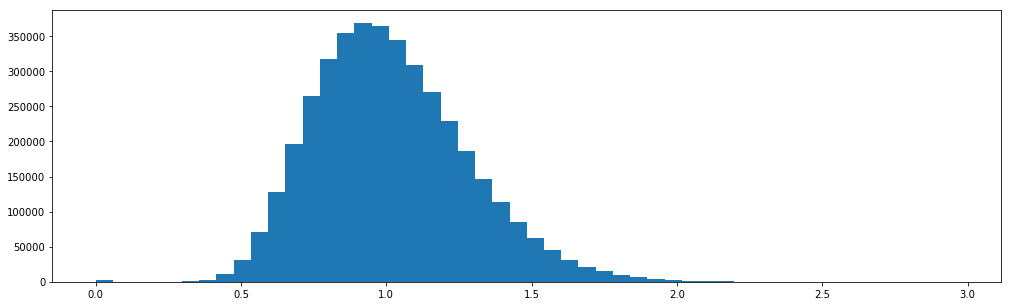

In [19]:
plt.hist(distances.reshape(-1), bins=50);

In [20]:
print('{} distances equal exactly zero.'.format(np.sum(distances == 0)))

2002 distances equal exactly zero.


Why are some distances equal to zero?

**Your answer here.** Distance of a song with itself must be zero. Since there are 2000 songs, hence atleast 2000 distances should be zero. Apart from that, the extra 2 zeros might signify that one more song might be close to another, leading 2 more zeros (not 1 more, due to symmetricity).

### 3.2 Weighted adjacency matrix

From our distances, we want to compute edge weights. If the distance is short, which means the tracks are similar, we want a strong edge. The most widespread kernel for that task is the Gaussian kernel, defined as
$$\mathbf{W}(u,v) = \exp \left( \frac{-d^2(u, v)}{\sigma^2} \right),$$
where $\sigma$ is a parameter which controls the width of the kernel.

Bonus. Can you think of another suitable kernel?

**Your answer here.** Another kernel performing a similar function can be defined as
$$\mathbf{W'}(u,v) = \exp \left( \frac{-| d(u, v) |}{\sigma} \right)$$

Compute below the weight of each edge.

Hints:
* At first, you can set the kernel width, $\sigma$, to the mean value of the distance. (It will preserve the distribution of distances.)
* Don't forget to set the diagonal to zero! We don't want self-connections.

In [21]:
kernel_width = distances.mean()
weights = np.exp(-np.square(distances) / (kernel_width ** 0.1))
#weights = np.exp(-np.square(distances) / (kernel_width ** 2))
for i in range(weights.shape[0]):
    weights[i][i] = 0

So we just created a fully connected graph. For our algorithms to be more efficient, we want to sparsify it. There are two main ways to sparsify a graph: i) thresholding all the weights smaller than an $\epsilon$, and ii) keep the $k$ strongest edges for each node. Implement below the second option. You can start with $k=100$.

Hints:
* You can use `np.argsort` to sort the weights.
* Be sure that your weight matrix stays symmetric.
* Look at both the sparsity pattern and the weight distribution as an indication of correctness.

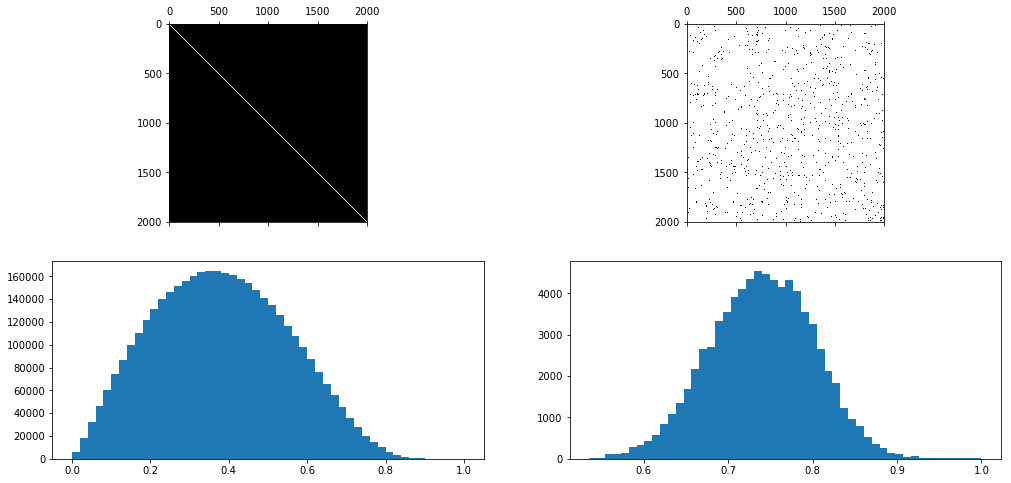

In [22]:
fix, axes = plt.subplots(2, 2, figsize=(17, 8))
def plot(weights, axes):
    axes[0].spy(weights)
    axes[1].hist(weights[weights > 0].reshape(-1), bins=50);
plot(weights, axes[:, 0])

NEIGHBORS = 25
#NEIGHBORS = 100
# Your code here.

#Find sorted indices of weights for each row
indices = np.argsort(weights, axis = 1)

#Create a zero matrix which would later be filled with sparse weights
n_weights = np.zeros((weights.shape[0], weights.shape[1]))

#Loop that iterates over the 'K' strongest weights in each row, and assigns them to sparse matrix, leaving others zero
for i in range(indices.shape[0]):
    for j in range(indices.shape[1] - NEIGHBORS, indices.shape[1]):
        col = indices[i][j]
        n_weights[i][col] = weights[i][col]  

#Imposing symmetricity
big = n_weights.T > n_weights
n_weights_s = n_weights - n_weights * big + n_weights.T * big
            
plot(n_weights_s, axes[:, 1])

In [23]:
#Imposing symmetricity means that there might be more than 'K' strongest weights for each node
np.count_nonzero(n_weights_s, axis = 1)

array([39, 33, 30, ..., 31, 27, 29], dtype=int64)

### 3.3 Bonus: visualize the adjacency matrix

Can you think of a way to observe if the two genres form clusters in the graph we created? You should only use the weight matrix `weights` and the genre labels `tracks['genre']`.

In [24]:
# Your code here.

#Creating a dictionary of tracks and genres
genre_dict = dict(tracks['genre']) 

#List of nodes, numbered
nodes = range(2000) 

#List of values of the aforementioned dictionary
genre_values = genre_dict.values() 

#Creating a new dictionary from nodes and genres
network_num = dict(zip(nodes, genre_values))

#Indicator matrix which would contain information on type of connection between nodes based on genre values
drawn_matrix = np.zeros((2000,2000))

#Sorting the nodes so that all genres valued 12 are together, and all genres valued 21 are together
new_order = [x for _,x in sorted(zip(genre_values, nodes))]

#Rearranging the weight matrix according to this new ordering of nodes
n_weights_s_new = n_weights_s[:, new_order][new_order]

#Filling the indicator matrix
for row in range(2000):
    for col in range(2000):
        # check if edge exists
        if n_weights_s_new[row][col] != 0:
            # red if nodes of genre 12 have a connection
            if network_num[new_order[row]] == 12 and network_num[new_order[col]] == 12:
                drawn_matrix[row][col] = 0.25
            # blue if nodes of genre 21 have a connection
            elif network_num[new_order[row]] == 21 and network_num[new_order[col]] == 21:
                drawn_matrix[row][col] = 0.5
            # green if there is a cross connection
            else:
                drawn_matrix[row][col] = 1.0
        else:
            drawn_matrix[row][col] = 0.0  # no edge is marked as gray
drawn_matrix

array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]])

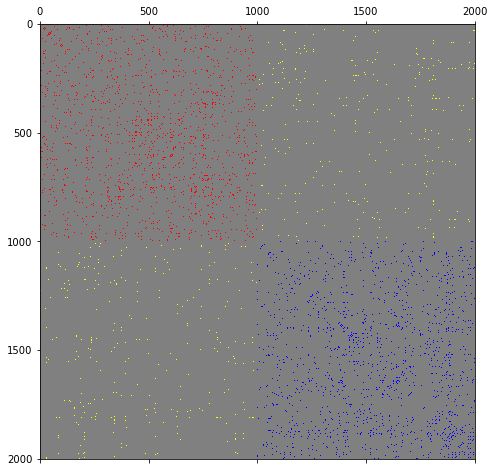

In [25]:
def make_colormap(seq):
    """Return a LinearSegmentedColormap
    seq: a sequence of floats and RGB-tuples. The floats should be increasing
    and in the interval (0,1).
    """
    seq = [(None,) * 3, 0.0] + list(seq) + [1.0, (None,) * 3]
    cdict = {'red': [], 'green': [], 'blue': []}
    for i, item in enumerate(seq):
        if isinstance(item, float):
            r1, g1, b1 = seq[i - 1]
            r2, g2, b2 = seq[i + 1]
            cdict['red'].append([item, r1, r2])
            cdict['green'].append([item, g1, g2])
            cdict['blue'].append([item, b1, b2])
    return mcolors.LinearSegmentedColormap('CustomMap', cdict)

c = mcolors.ColorConverter().to_rgb
rvb = make_colormap([c('gray'), c('red'), 0.25, c('red'), c('blue'), 0.5, c('blue'), c('yellow'), 0.75, c('yellow')])

fig, ax = plt.subplots(figsize=(8, 8))
ax.matshow(drawn_matrix, vmin=0.0, vmax=1.0, cmap=rvb)
plt.show()

**Remarks - **As we can clearly see, there is a **dense** connection between nodes of **similar genre** (indicated by denseness of red and blue colors, corresponding to genre 12 and 21 respectively). But, the **cross connection** region of the graph is **relatively sparse** (indicated by the sparsity of the yellow color, corresponding to the connection between a node of genre 12 and a node of genre 21). This difference in densities is a clear indicator of presence of clusters.

### 3.4 Degrees

Compute below the degree vector.

Hints:
* Again, looking at the degree distribution will help you identify any mistake.

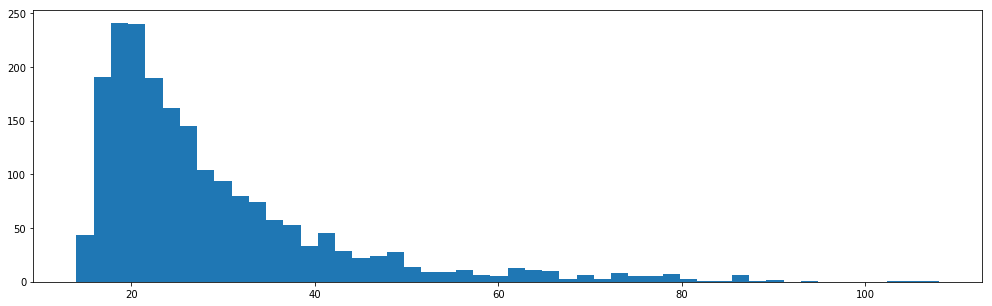

In [26]:
degrees = np.sum(n_weights_s, axis = 0)
plt.hist(degrees, bins = 50);

### 3.5 Graph Laplacian

We will later need the Fiedler vector. Shall we compute the combinatorial or the normalized Laplacian? 

**Your answer here.** We should compute the normalized Laplacian, the reason for which is explained as follows:

Unnormalized laplacian serves in the approximation of the minimization of $Ratio\ Cut$, while normalized laplacian serves in the approximation of the minimization of $N\ Cut$. In general, clustering has two different objectives:

1. We want to find a partition such that points in different clusters are dissimilar to each other, that is we want to minimize the between-cluster similarity. In the graph setting, this means to minimize $\sum_{i \in A,\ j \in \bar A} w_{ij}$.
2. We want to find a partition such that points in the same cluster are similar to each other, that is we want to maximize the within-cluster similarity. This means that $\sum_{i,\ j \in A} w_{ij}$ and $\sum_{i,\ j \in \bar A} w_{ij}$ should be maximized.

Both RatioCut and Ncut directly implement the first point by explicitly incorporating $cut\ (A,\ \bar A)$ in the objective
function. However, concerning the second point, both algorithms behave differently. Note that

$$\sum_{i,\ j \in A} w_{ij} = \sum_{i \in A,\ j \in A \cup \bar A} w_{ij} - \sum_{i \in A,\ j \in \bar A} w_{ij} = vol(A) - cut(A,\ \bar A)$$

Hence, the within-cluster similarity is maximized if $cut(A,\ \bar A)$ is small `and` if $vol(A)$ is large. In the case of $N\ Cut$, this is also part of the objective function as we want to maximize both $vol(A)$ and $vol(\bar A)$. Thus, $N\ Cut$ implements the second objective.

Now consider the case of $Ratio\ Cut$. Here the objective is to maximize $|A|$ and $|\bar A|$ instead of $vol(A)$ and $vol(\bar A)$. But, $|A|$ and $|\bar A|$ are not necessarily related to the within-cluster similarity, as the within-cluster similarity depends on the edges and not on the number of vertices in $A$. So minimizing $Ratio\ Cut$ does not attempt to maximize the within-cluster similarity.



Implement your choice below. 

Hints:
* Compare the sparsity pattern of the Laplacian to the one of the weight matrix.

**Answer -** Sparsity pattern is exactly the same as weight matrix except that the diagonals are now non zero and non-diagonal entries are the negative of weight matrix.

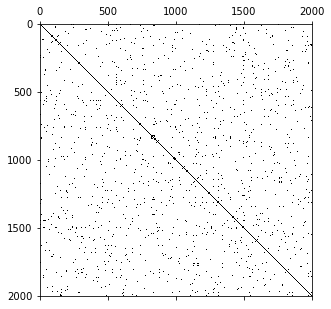

In [27]:
#Degree matrix D
deg_mat = np.diag(degrees)
#Laplacian matrix L = D - W
laplacian = deg_mat - n_weights_s

#D^(-1/2)
degrees_new = np.power(degrees, -0.5)
D = np.diag(degrees_new)
#Normalized laplacian matrix L_norm = D^(-1/2) * L * D^(-1/2)
lap_norm = np.dot(D, np.dot(laplacian, D))

plt.spy(lap_norm);

For efficient storage and computation, we can store this sparse matrix in a [compressed sparse row (CSR)](https://en.wikipedia.org/wiki/Sparse_matrix#Compressed_sparse_row_.28CSR.2C_CRS_or_Yale_format.29) format.

In [28]:
lap_norm = sparse.csr_matrix(lap_norm)

Compute the number of remaining edges in the graph.

In [29]:
# Your code here.
num = sum(np.count_nonzero(n_weights_s, axis = 1))
print('Out of 4000000 edges, only {} remain, which is only {}%'.format(num, num/40000))

Out of 4000000 edges, only 77638 remain, which is only 1.94095%


## 4 Eigendecomposition of the graph Laplacian

The whole point of spectral graph theory is to compute the eigendecomposition of the Laplacian. We however don't need the full eigendecomposition (a.k.a. the graph Fourier basis) here. Compute the 10 eigenvectors with the smallest eigenvalues with one of the following functions: `np.linalg.eig`, `np.linalg.eigh`, `sparse.linalg.eigs`, `sparse.linalg.eigsh`. Justify your choice.

**Your answer here.** Matrix is sparse and symmetric, so `sparse.linalg.eigsh` is the logical choice.

In [30]:
#eigenvalues, eigenvectors = np.linalg.eigh(sparse.csr_matrix.todense(lap_norm))
eigenvalues, eigenvectors = sparse.linalg.eigsh(lap_norm, which = 'SM', k = 10)

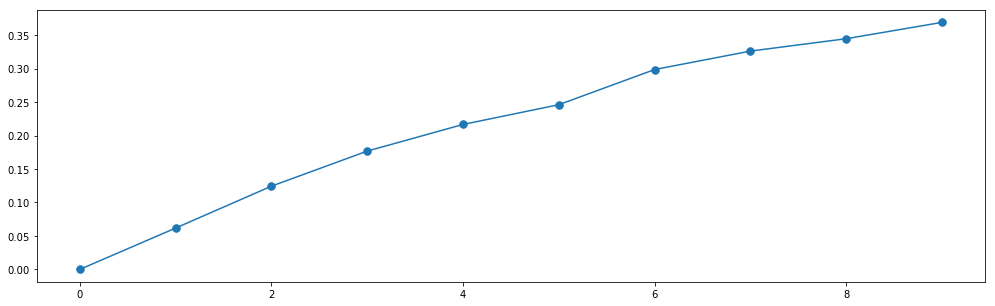

In [31]:
plt.plot(eigenvalues, '.-', markersize=15);

* Why can we diagonalize the graph Laplacian in the first place? 

**Your answer here.** $L_{norm} = D^{-1/2}LD^{-1/2} = I - D^{-1/2}WD^{-1/2}$. $I$, $D^{-1/2}$ and $W$ are symmetric. Hence, $L_{norm}$ is a symmetric matrix. All symmetric matrices are diagonalizable. Hence, normalized laplacian is diagonalizable.

* Why are all the eigenvalues real?

**Your answer here.** All symmetric matrices have real eigenvalues. Hence, normalized laplacian has real eigenvalues.

* Why are all the eigenvalues non-negative?

**Your answer here.** Consider an eigenvector $g$ of $L_{norm}$ with eigenvalue $\lambda$. And suppose $g = D^{-1/2}f$. Then:

$$\lambda = \frac{\langle g,\ L_{norm}g \rangle}{\langle g,\ g\rangle} = \frac{\langle g,\ D^{-1/2}LD^{-1/2}g \rangle}{\langle g,\ g\rangle} = \frac{\langle f,\ Lf \rangle}{\langle D^{-1/2}f,\ D^{-1/2}f\rangle} = \frac{\sum_{u\sim v} (f(u) - f(v))^2}{\sum_{v} f(v)^2 d_v} \ge 0$$

where $\langle f,\ g \rangle = \sum_{v} f(v)g(v)$, a sum over all vertices of $v$, and $\sum_{u\sim v}$ denotes the sum over all unordered pairs of adjacent vertices $\{u,\ v\}$.

### 4.1 Connectedness

Is the graph connected? Justify. Knowing how we built the graph, can we ensure it is connected?

In [32]:
# Your code here.
np.set_printoptions(suppress=True)
print(eigenvalues)

[ 0.          0.0617332   0.1243073   0.1766938   0.21653236  0.24602593
  0.29855565  0.32610339  0.34459015  0.3690196 ]


**Your answer here.** Multiplicity of the zero eigenvalue denotes the number of discrete connected components in the graph. Since there is only 1 zero eigenvalue (as seen from the graph above), hence the graph has only one connected component, i.e., the graph is connected. We made the graph sparse by taking only `K` strongest weights. We can't be sure that way.

### 4.2 Eigenvector question

What do you expect as the result of the below computation? Justify. Do you get the value you expected? If not, why?

Note that `x @ y` (introduced in Python 3.5) is equivalent to `np.matmul(x, y)`. You should prefer the former as it makes it easier to read formulas.

In [33]:
np.set_printoptions(suppress=True)
res = np.array([np.sum(lap_norm @ (2 * eigenvectors[:, 0]))])
print(res)

[ 0.]


**Your answer here.** Since first eigenvalue is zero, hence the first eigenvector belongs to nullspace of $L_{norm}$. Hence, the output of the above code is zero.

## 5 Visualization and clustering

Finally, let's use the data and graph we prepared. When [exploring data](https://en.wikipedia.org/wiki/Exploratory_data_analysis), it's often useful to visualize an entire dataset. Because for us humans it's hard to look at data in 140 dimensions, we need to somehow reduce the dimensionality to 2 or 3 and visualize the data in this more familiar space. While such a reduction will obviously be destructive, many algorithms have been developed to preserve certain properties.

### 5.1 Principal component analysis (PCA)

[PCA](https://en.wikipedia.org/wiki/Principal_component_analysis) is a standard algorithm to reduce the dimensionality of a dataset. It computes the axes of principal variance and project the data on them. It does only use the features we computed, not the graph. We show it here for comparison. (We use [scikit-learn](http://scikit-learn.org), a very convenient library for Machine Learning.)

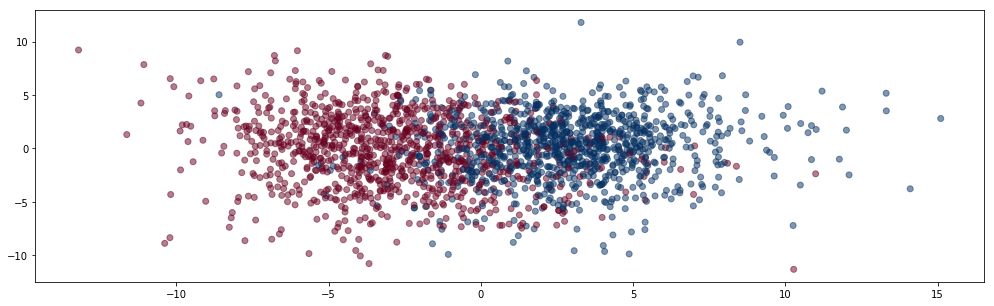

In [34]:
features_pca = decomposition.PCA(n_components=2).fit_transform(features)
genres = preprocessing.LabelEncoder().fit_transform(tracks['genre'])
plt.scatter(features_pca[:, 0], features_pca[:, 1], c=genres, cmap='RdBu', alpha=0.5);

### 5.2 Graph embedding

Instead of using the features directly, we can try to visualize our similarity graph. That graph is embedded in an ambiant space of 140 dimensions (the number of features, that is the number of MFCCs times the number of summary statistics) at first, i.e. each node has a position in an 140-dimensional Euclidean space. Because we cannot visualize such an high-dimensional space, we want to embed the graph in a 2D space.

One way to embed a graph is to use the value of the eigenvectors as coordinates. For the below plot, use the value of the second eigenvector as the x coordinate of a node, and the value of the third eigenvector as the y coordinate. The color is indicated by the genre.

Why don't we use the first eigenvector? 

**Your answer here.** First eigenvalue is 0, which means first eigenvector belongs to nullspace of $L_{norm}$. For $L$, first eigenvector is simply the $𝟙$ vector because all elements in the row of $L$ sum to zero. Similarly, for $L_{norm}$, it is $D^{-1/2}𝟙$ which is a constant vector, and using it would mean that there would be no variability along one coordinate, i.e., it would be useless.

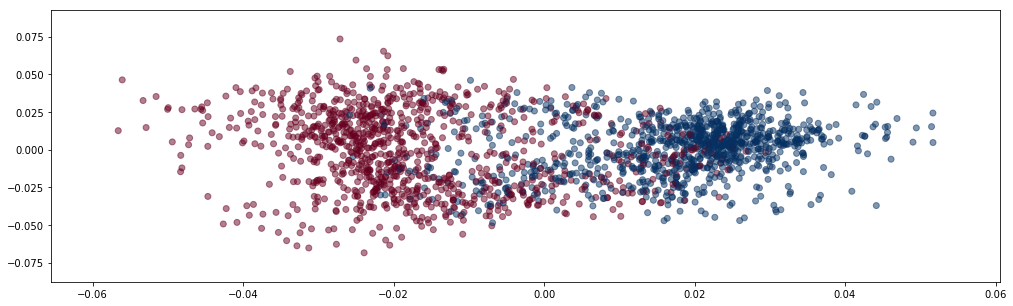

In [35]:
x = [eigenvectors[:, 1]]
y = [eigenvectors[:, 2]]
plt.scatter(x, y, c=genres, cmap='RdBu', alpha=0.5);

See how well this plot summarizes 2GB of data and 2000 tracks! We could now design a playlist generator as a random walk on this similarity graph and visualize its trajectory as it hops from track to track. :)

### 5.3 Clustering

Note how we did not try to build a machine to recognize the musical genre given a track (that would have been a [classification problem](https://en.wikipedia.org/wiki/Statistical_classification)). We did merely try to visualize the data, by means of PCA and a graph embedding algorithm. What does it tell us that genre clearly appears in our visualization?

**Your answer here.** The two genres form visibly different clusters with very less overlapping indicating a strong uncorrelatedness.

As such, we can try to cluster the tracks with the Fiedler vector, and look if the (unsupervised) clustering agrees with the *ground truth* genre categorization. Reproduce below the above scatter plot, but with the sign of the Fiedler vector as the color instead of the genre.

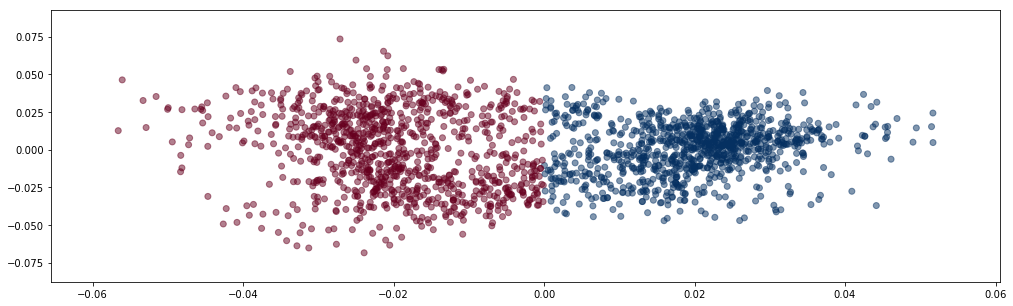

In [36]:
f_vector = eigenvectors[:, 1]
labels = np.zeros((2000,))
for i in range(2000):
    if f_vector[i] > 0:
        labels[i] = 1

plt.scatter(x, y, c=labels, cmap='RdBu', alpha=0.5);

### 5.4 Error rate

How many tracks were wrongly categorized by the Fiedler vector, according to the Rock / Hip-Hop ground truth?

In [37]:
err = np.count_nonzero(labels - genres)
print('{} errors ({}%)'.format(err, 100*err/len(labels)))

271 errors (13.55%)


Tune some parameters (e.g. `kernel_width`, `NEIGHBORS`), discard some features (section 2.4), change the distance metric (section 3.1) to get less errors. You should get an error rate below 15% (i.e. less than 300 errors in total). Try to understand the effect of each parameter. After data cleaning, parameter tuning is the other dirty work of a data scientist! Be aware that tuning the parameters on a specific dataset will lead to [overfitting](https://en.wikipedia.org/wiki/Overfitting).

## 6 Conclusion

Among other things, this assignment showed us that a graph can be useful for e.g. visualization or clustering, even when there is none in the original data. One of the design goal of this assignment, while dealing with real data, was to follow the complete Data Science process, from data acquisition to interpretation of the results. The exploitation of the data showed us that a machine can discern musical genres by looking at pairwise distances between spectral features extracted from audio recordings.

### 6.1 Bonus

What is the name of the technique we used to visualize the data in the last two plots? What does it try to preserve when reducing the dimensionality (of the ambiant space) from 140 to 2?

**Your answer here.** The technique is called Laplacian Embedding / Spectral Graph Embedding. Points which are similar/closer in high dimensional space remain closer when transformed to low dimensional space using this technique.